In [3]:
import Pkg;
Pkg.activate(@__DIR__);
Pkg.instantiate()

using RobotZoo:Cartpole
using RobotDynamics
using ForwardDiff
using LinearAlgebra
using StaticArrays
using SparseArrays
using ControlSystems

using Plots
using Printf

  Activating project at `c:\Users\sesch\Git\Controller`


Precompiling

project...


  ✓ StructArrays → StructArraysGPUArraysCoreExt


  1 dependency successfully precompiled in 4 seconds. 373 already precompiled.


In [40]:
# Cartpole Dynamics
# TODO: measure mc mp and l
mc = 0.1  # mass of the cart in kg (10)
mp = 0.18   # mass of the pole (point mass at the end) in kg
l = 0.35   # length of the pole in m
g = 9.81  # gravity m/s^2

a = Cartpole(mc, mp, l, g)
h = 1/30

function dynamics_rk4(x,u)
    #RK4 integration with zero-order hold on u
    f1 = RobotDynamics.dynamics(a, x, u)
    f2 = RobotDynamics.dynamics(a, x + 0.5*h*f1, u)
    f3 = RobotDynamics.dynamics(a, x + 0.5*h*f2, u)
    f4 = RobotDynamics.dynamics(a, x + h*f3, u)
    return x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
end

##

Nx = 4     # number of state
Nu = 1     # number of controls
Tfinal = 5.0 # final time
Nt = Int(Tfinal/h)+1    # number of time steps
thist = Array(range(0,h*(Nt-1), step=h));

##

# Cost weights

# TODO: tune these!
# Q = collect(Diagonal([1.0*ones(2); 1.0*ones(2)]));
Q = collect(Diagonal([0; 1 ; 1 ; 0.5]));
R = 20;
Qn = Array(100.0*I(Nx));

##

# Goal state
xg = [0; pi/2; 0; 0];

##

# Linearized state and control matrices
A = ForwardDiff.jacobian(dx->dynamics_rk4(dx, 0), xg)
B = ForwardDiff.derivative(du->dynamics_rk4(xg, du), 0)
display(Q)
display(A)
display(B)

##

# Might need to invert some of the gains depending on rotation / translation directions of the joints
K = dlqr(A,B,Q,R)



4×4 Matrix{Float64}:
 0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0
 0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.5

4×4 Matrix{Float64}:
 1.0  -0.000315322  0.01  -3.15321e-6
 0.0   1.0          0.0    0.01
 0.0  -0.0630644    1.0   -0.000945965
 0.0   0.000205753  0.0    1.0

4-element SVector{4, Float64} with indices SOneTo(4):
  0.00017857144735971626
 -1.1916912407284371e-7
  0.03571431201790314
 -4.7667726530774455e-5

1×4 Matrix{Float64}:
 -1.57072e-10  -43.8619  -0.222441  -381.679

In [17]:
# state vector = [x, theta, xdot, thetadot]
test_vector = [0, 0, 0, 0]
test_control = -K*test_vector
print(test_control)

[0.0]

In [20]:
test_vector = [-0.05, 0, 0, 0]
test_control = -K*test_vector
print(test_control)

[-0.14791402981049404]

In [21]:
test_vector = [0.05, 0, 0, 0]
test_control = -K*test_vector
print(test_control)

[0.14791402981049404]

In [36]:
test_vector = [0, 0.001, 0, -0.0001]
test_control = -K*test_vector
print(test_control)

[0.46268724241519915]

In [37]:
test_vector = [0, 0.001, 0, 0.0001]
test_control = -K*test_vector
print(test_control)

[9.498735919335902]

In [49]:

# Cartpole params
m1 = 0.2
m2 = 0.2
ℓ = 0.35
J = 0.00816 # mass moment of inertia of pendulum
# b = 0.1
friction = 0

g = 9.81

h = 1/100

##

function cartpole_dynamics(x,u)
    r = x[1] # cart position
    θ = x[2] # pole angle
    ṙ = x[3] # change in cart position
    θ̇ = x[4] # change in pole angle
  
    F = u[1]
  
    a = [(m1+m2) m2*ℓ*cos(θ); m2*ℓ*cos(θ) J+m2*ℓ^2]
    b = [F - friction*ṙ + m2*ℓ*sin(θ)*θ̇ ^2; -m2*g*ℓ*sin(θ)]
  
    ẍ = a^(-1)*b
  
    return [ṙ; θ̇ ; ẍ[1]; ẍ[2]]
end



function dynamics_rk4(x,u)
    #RK4 integration with zero-order hold on u
    f1 = cartpole_dynamics(x, u)
    f2 = cartpole_dynamics(x + 0.5*h*f1, u)
    f3 = cartpole_dynamics(x + 0.5*h*f2, u)
    f4 = cartpole_dynamics(x + h*f3, u)
    return x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
end

##

Nx = 4     # number of state
Nu = 1     # number of controls
Tfinal = 5.0 # final time
Nt = Int(Tfinal/h)+1    # number of time steps
thist = Array(range(0,h*(Nt-1), step=h));

##

# Cost weights

# TODO: tune these!
# Q = collect(Diagonal([1.0*ones(2); 1.0*ones(2)]));
Q = collect(Diagonal([0; 1 ; 1 ; 0.5]));
R = 2;
Qn = Array(100.0*I(Nx));

##

# Goal state
xg = [0; 0; 0; 0];

##

# Linearized state and control matrices
A = ForwardDiff.jacobian(dx->dynamics_rk4(dx, 0), xg)
B = ForwardDiff.derivative(du->dynamics_rk4(xg, du), 0)
display(Q)
display(A)
display(B)

##

# Might need to invert some of the gains depending on rotation / translation directions of the joints
K = dlqr(A,B,Q,R)



4×4 Matrix{Float64}:
 0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0
 0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.5

4×4 Matrix{Float64}:
 1.0   0.000294314  0.01  9.8132e-7
 0.0   0.998318     0.0   0.00999439
 0.0   0.0588462    1.0   0.000294314
 0.0  -0.336264     0.0   0.998318

4-element Vector{Float64}:
  0.00020000346263162014
 -0.00042859121503782937
  0.03999648549360837
 -0.08569420282061925

1×4 Matrix{Float64}:
 3.00687e-9  -0.58814  0.685566  -0.383099

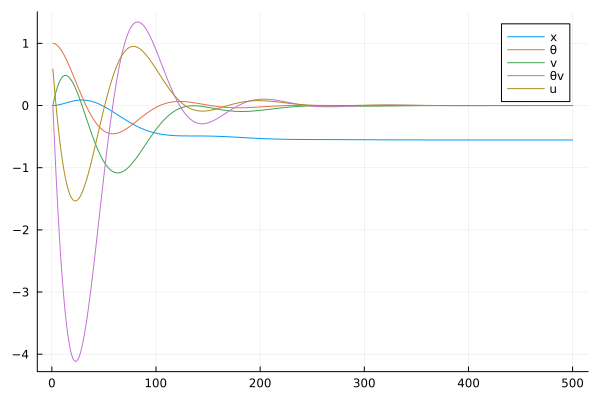

In [50]:
Nsim = 500
x_lqr = [zeros(nx) for i = 1:Nsim]
x_lqr[1] = [0; 1; 0; 0]
u_lqr = zeros(Nsim-1)

for k = 1:Nsim-1
    # u_lqr[k] = -cache.Kinf*(x_lqr[k] - [0; 1; 0; 0])
    u = -K*(x_lqr[k] - [0; 0; 0; 0])
    u_lqr[k] =  u[1]
    x_lqr[k+1] = A*x_lqr[k] + B*u_lqr[k]
end

plot(hcat(x_lqr...)', label=["x" "θ" "v" "θv"])
plot!(hcat(u_lqr...)', label="u")

In [ ]:
## NEW

## NEW STUFF

In [3]:
# import Pkg; Pkg.add("TrajOptPlots")

In [4]:
import Pkg;
Pkg.activate(@__DIR__);
Pkg.instantiate()


##

using LinearAlgebra
using ForwardDiff
using Plots
using Random 
using Printf
# using MeshCat
using TrajOptPlots
using RobotZoo:Cartpole
using StaticArrays
# using GeometryTypes
using ControlSystems
# using ColorTypes

using Plots

##

###### Cartpole params
#### Pole angle is measured as an offset from vertical (vertical = 0 radians) - clockwise is positive
#### Length is distance to the center of mass and is assumed to be half the length of the pole for moment of inertia calculation
mc = 0.5 # mass of the cart
mp = 0.2 # mass of the pole
ℓ = 0.5 # distance to the center of mass

g = 9.81

h = 1/100

##


  Activating project at `~/Desktop/rexlab/cartpole_controls`


┌ Warning: Module Plots with build ID fafbfcfd-4cee-f039-0004-410567b3344e is missing from the cache.
│ This may mean Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1793


┌ Warning: Module Plots with build ID fafbfcfd-4cee-f039-0004-410567b3344e is missing from the cache.
│ This may mean Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1793


┌ Warning: Module StatsBase with build ID fafbfcfd-b640-d56f-0004-40aa29fab575 is missing from the cache.
│ This may mean StatsBase [2913bbd2-ae8a-5f71-8c99-4fb6c76f3a91] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1793


┌ Warning: Module StatsBase with build ID fafbfcfd-b640-d56f-0004-40aa29fab575 is missing from the cache.
│ This may mean StatsBase [2913bbd2-ae8a-5f71-8c99-4fb6c76f3a91] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1793


┌ Warning: Module StatsBase with build ID fafbfcfd-b640-d56f-0004-40aa29fab575 is missing from the cache.
│ This may mean StatsBase [2913bbd2-ae8a-5f71-8c99-4fb6c76f3a91] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1793


┌ Warning: Module StatsBase with build ID fafbfcfd-b640-d56f-0004-40aa29fab575 is missing from the cache.
│ This may mean StatsBase [2913bbd2-ae8a-5f71-8c99-4fb6c76f3a91] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1793


┌ Warning: Module Distributions with build ID ffffffff-ffff-ffff-0000-dcf82bd0b29f is missing from the cache.
│ This may mean Distributions [31c24e10-a181-5473-b8eb-7969acd0382f] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1793


┌ Warning: Module Distributions with build ID ffffffff-ffff-ffff-0000-dcf82bd0b29f is missing from the cache.
│ This may mean Distributions [31c24e10-a181-5473-b8eb-7969acd0382f] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1793


┌ Warning: Module DiffEqBase with build ID ffffffff-ffff-ffff-0000-dcf8022844b4 is missing from the cache.
│ This may mean DiffEqBase [2b5f629d-d688-5b77-993f-72d75c75574e] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1793


┌ Warning: Module OrdinaryDiffEq with build ID ffffffff-ffff-ffff-0000-dcf7a88db179 is missing from the cache.
│ This may mean OrdinaryDiffEq [1dea7af3-3e70-54e6-95c3-0bf5283fa5ed] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1793


0.01

In [5]:

function cartpole_dynamics(x,u)
    r = x[1] # cart position
    θ = x[2] # pole angle
    rd = x[3] # change in cart position
    θd = x[4] # change in pole angle
    F = u[1] # force applied to cart
    
    θdd = (g*sin(θ) + cos(θ) * ((-F - mp*ℓ*θd^2 * sin(θ))/(mc + mp))) / (ℓ*(4/3 - (mp*cos(θ)^2)/(mc + mp)))
    xdd = (F + mp*ℓ*(θd^2*sin(θ) - θdd*cos(θ))) / (mc + mp)
  
    return [rd; θd; θdd; xdd]
end
function cartpole_rk4(x,u)
    #RK4 integration with zero-order hold on u
    f1 = cartpole_dynamics(x, u)
    f2 = cartpole_dynamics(x + 0.5*h*f1, u)
    f3 = cartpole_dynamics(x + 0.5*h*f2, u)
    f4 = cartpole_dynamics(x + h*f3, u)
    xn = x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
    return xn
end

##

# Goal state
xg = [0; 0; 0; 0];

##

# Linearized state and control matrices
A = ForwardDiff.jacobian(dx->cartpole_rk4(dx, 0), xg)
B = ForwardDiff.derivative(du->cartpole_rk4(xg, du), 0)
display(A)
display(B)

##

nx = 4 # number of states
nu = 1 # number of controls

##

# Cost weights
# TODO: tune these! (cart position, pole angle, cart linear velocity, pole angular velocity)
Q = collect(Diagonal([1; 1; 1; 1]));
R = 0.1;

##

# Might need to invert some of the gains depending on rotation / translation directions of the joints
K = dlqr(A,B,Q,R)

# K[1] = 0


4×4 Matrix{Float64}:
 1.0   0.000936388  0.01  3.12136e-6
 0.0   0.999866     0.0   0.00999955
 0.0   0.187273     1.0   0.000936388
 0.0  -0.0267534    0.0   0.999866

4-element Vector{Float64}:
 -0.00013634944834710748
  9.09070640495868e-5
 -0.02726705206611571
  0.018181007438016532

1×4 Matrix{Float64}:
 2.91777  43.1573  5.11975  16.049

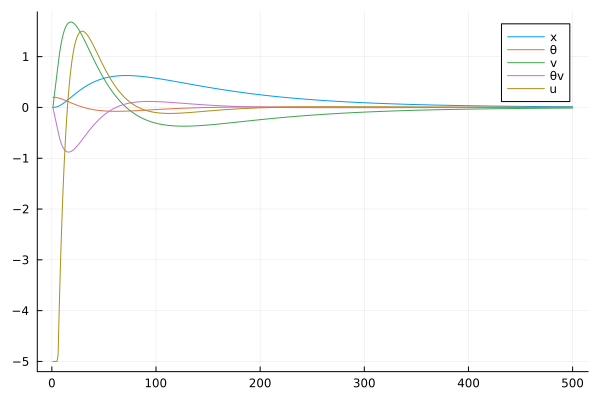

In [6]:

##

control_lim = 5

Nsim = 500
x_lqr = [zeros(nx) for i = 1:Nsim]
x_lqr[1] = [0; .2; 0; 0]
u_lqr = zeros(Nsim-1)

for k = 1:Nsim-1
    u = -K*(x_lqr[k] - xg)
    u_lqr[k] = min(control_lim, max(u[1], -control_lim))
    x_lqr[k+1] = cartpole_rk4(x_lqr[k], u_lqr[k])
end

plot(hcat(x_lqr...)', label=["x" "θ" "v" "θv"])
plot!(hcat(u_lqr...)', label="u")